# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import os

from preprocessing import preprocess, preprocess_with_ohe

In [ ]:
print(tf.config.list_physical_devices('GPU'))


[]


# Data donwload and preprocess

In [2]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)

#if running on colab
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    #data_dir='D:\progetto-daml\\new_dataset',
    with_info=True,
    #download=False
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.BYUZTK_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
'''
#creazione dei tre dataset: train, val, test
DATA_DIR    = 'D:\progetto-daml\PlantVillage-Dataset\\raw\color'
#DST_DIR    = 'D:\progetto-daml\PlantVillage-Dataset\\final_data'
TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1
IMG_SIZE   = (128,128)
SEED       = 42
BATCH_SIZE = 32

ds_train = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_FRAC,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
)

ds_val = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
)

ds_test = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.1,
    subset="validation",
    seed=SEED+1,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
)
'''

Found 54305 files belonging to 38 classes.
Using 43445 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Found 54305 files belonging to 38 classes.
Using 5430 files for validation.


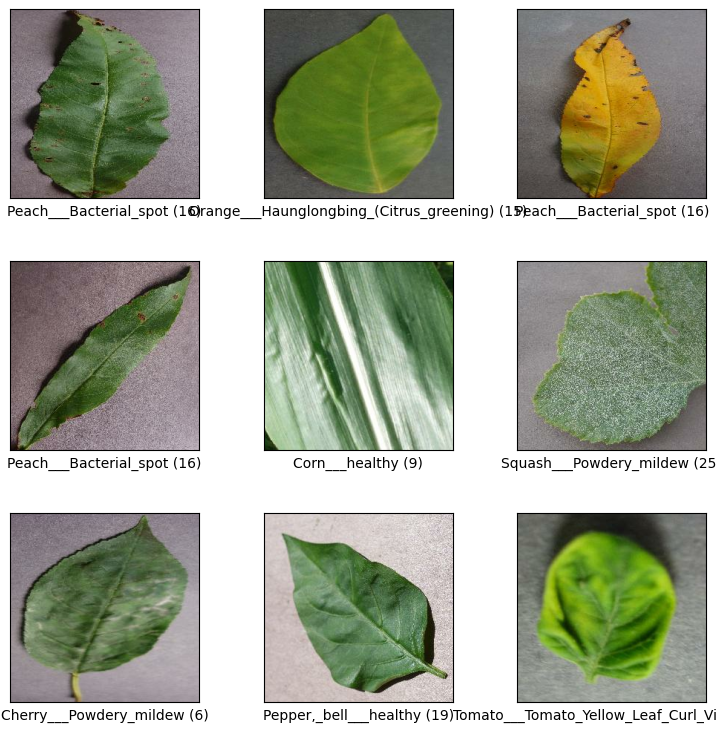

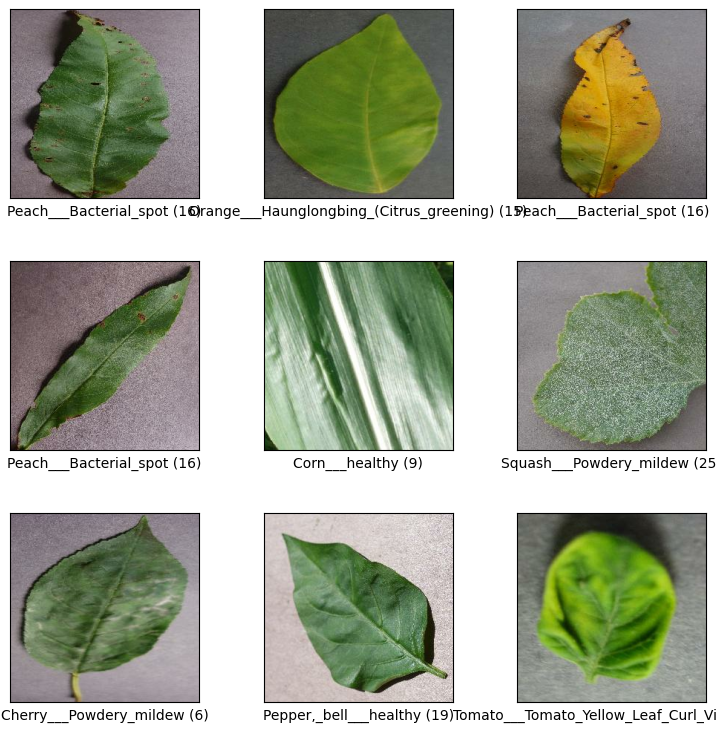

In [ ]:
# Show example from the dataset
tfds.show_examples(ds_train, ds_info)

In [ ]:
FAM_SPLIT = True  # if True, split the dataset by family, else by class

In [ ]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
APPLY_DATA_AUGMENTATION = False
N_EPOCHS = 12
VERBOSE = True

In [ ]:
#define class_names as folders names
class_names = ds_info.features['label'].names
if VERBOSE:
  print(class_names)

In [ ]:
#families counter

if FAM_SPLIT:
  counter = 0
  families = sorted({name.split('___')[0] for name in class_names})
  split_labels = families
  if VERBOSE: 
    print(families)
    print(len(families))
else:
  split_labels = class_names

NUM_LAB = len(split_labels)

In [ ]:
#index assignment for each family

if FAM_SPLIT:
  family_map = [
    families.index(name.split('___')[0])
    for name in class_names
  ]

  family_map = tf.constant(family_map, dtype=tf.int32)

  if VERBOSE:
    print(family_map)

In [ ]:
#folder name -> family index (Apple = 1, Blueberry = 2 etc.)
def folder_to_fam_ohe(image, label):
  fam_index = tf.gather(family_map, label)
  fam_ohe = tf.one_hot(fam_index, NUM_LAB)
  return image, fam_ohe

In [ ]:
if FAM_SPLIT:
    ds_train_ohe = ds_train.map(folder_to_fam_ohe)
    ds_val_ohe = ds_val.map(folder_to_fam_ohe)
    ds_test_ohe = ds_test.map(folder_to_fam_ohe)


In [ ]:
# Preprocess and batch the datasets
if FAM_SPLIT:
    if APPLY_DATA_AUGMENTATION:
        print("Data augmentation is enabled.")
        train_ds_ohe = ds_train_ohe.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation
    else:
        print("Data augmentation is disabled.")
        ds_train_ohe = ds_train_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation

    ds_val_ohe = ds_val_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    ds_test_ohe = ds_test_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
else:
    if APPLY_DATA_AUGMENTATION:
        print("Data augmentation is enabled.")
        train_ds_ohe = ds_train_ohe.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation
    else:
        print("Data augmentation is disabled.")
        ds_train_ohe = ds_train_ohe.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation
    
    ds_val_ohe = ds_val_ohe.map(preprocess_with_ohe).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    ds_test_ohe = ds_test_ohe.map(preprocess_with_ohe).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Data augmentation is disabled.


In [ ]:
# Sample visualization function
def display_samples_with_labels(dataset, num_samples=5):
  plt.figure(figsize=(10, 2 * num_samples))
  for i, (image, disease_label) in enumerate(dataset.take(num_samples)):
    d_label = disease_label.numpy()
    folder_name = class_names[d_label]
    fam_idx = family_map[d_label].numpy()
    family_name = families[fam_idx]
    fam_ohe = tf.one_hot(fam_idx, NUM_LAB)


    # Visualization options
    ax = plt.subplot(num_samples, 1, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"Folder: {folder_name}  |  Family: {family_name} | OHE: {fam_ohe}")
  plt.tight_layout()
  plt.show()

#Visualization of train samples
display_samples_with_labels(ds_train)

# CNN model definition

In [14]:
from keras.models import Sequential, Model
from keras.layers import Resizing, Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [15]:
#model definition
def simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                num_classes=14):
    model = Sequential([
        Resizing(128, 128, input_shape=(None, None, 3)),
        # Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, (5, 5), padding='same'),
        # BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        # Dropout(0.2),
        Conv2D(32, (5, 5), padding='same'),
        # BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        # Dropout(0.2),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


'''
def simple_cnn(num_classes=38):
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    #x = Rescaling(1./255, name='rescale')(inputs)
    x = Conv2D(16, (3, 3), name='conv_1', padding="same")(inputs)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Activation('relu',name='activ_1')(x)
    x = MaxPooling2D((2, 2),name='maxpool_1')(x)

    x = Conv2D(32, (3, 3), name='conv_2', padding='same')(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Activation('relu',name='activ_2')(x)
    x = MaxPooling2D((2, 2),name='maxpool_2')(x)
    x = Dropout(0.2,name='dropout_1')(x)

    x = Conv2D(128, (3, 3), name='conv_3', padding='same')(x)
    x = BatchNormalization(name='batch_norm_3')(x)
    x = Activation('relu',name='activ_3')(x)
    x = MaxPooling2D((2, 2),name='maxpool_3')(x)
    x = Dropout(0.3,name='dropout_2')(x)

    x = GlobalAveragePooling2D(name='global_avgpool')(x)
    x = Dropout(0.5,name='dropout_3')(x)

    x = Dense(num_classes, activation='softmax', name='fam_out')(x)

    model = Model(inputs=inputs, outputs=x)
    return model'''


'\ndef simple_cnn(num_classes=38):\n    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))\n    #x = Rescaling(1./255, name=\'rescale\')(inputs)\n    x = Conv2D(16, (3, 3), name=\'conv_1\', padding="same")(inputs)\n    x = BatchNormalization(name=\'batch_norm_1\')(x)\n    x = Activation(\'relu\',name=\'activ_1\')(x)\n    x = MaxPooling2D((2, 2),name=\'maxpool_1\')(x)\n\n    x = Conv2D(32, (3, 3), name=\'conv_2\', padding=\'same\')(x)\n    x = BatchNormalization(name=\'batch_norm_2\')(x)\n    x = Activation(\'relu\',name=\'activ_2\')(x)\n    x = MaxPooling2D((2, 2),name=\'maxpool_2\')(x)\n    x = Dropout(0.2,name=\'dropout_1\')(x)\n\n    x = Conv2D(128, (3, 3), name=\'conv_3\', padding=\'same\')(x)\n    x = BatchNormalization(name=\'batch_norm_3\')(x)\n    x = Activation(\'relu\',name=\'activ_3\')(x)\n    x = MaxPooling2D((2, 2),name=\'maxpool_3\')(x)\n    x = Dropout(0.3,name=\'dropout_2\')(x)\n\n    x = GlobalAveragePooling2D(name=\'global_avgpool\')(x)\n    x = Dropout(0.5,

In [16]:
model = simple_cnn()
#model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,070 (66.68 KB)

 Trainable params: 17,070 (66.68 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
optimizer = Adam(learning_rate=0.0002)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
if APPLY_DATA_AUGMENTATION:
    check_point_filename = 'best_model_w_augmentation.h5'
else:
    check_point_filename = 'best_model_wo_augmentation.h5'

In [ ]:
history = model.fit(
    ds_train_ohe,
    validation_data=ds_val_ohe,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(check_point_filename, monitor='val_loss', save_best_only=True, verbose=1),
        # ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

Epoch 1/12
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3522 - loss: 2.2175
Epoch 1: val_loss improved from inf to 1.75836, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.3522 - loss: 2.2174 - val_accuracy: 0.4640 - val_loss: 1.7584
Epoch 2/12
2715/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4877 - loss: 1.6569
Epoch 2: val_loss improved from 1.75836 to 1.54263, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - accuracy: 0.4877 - loss: 1.6568 - val_accuracy: 0.5121 - val_loss: 1.5426
Epoch 3/12
2712/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5422 - loss: 1.4299
Epoch 3: val_loss improved from 1.54263 to 1.33595, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.5422 - loss: 1.4298 - val_accuracy: 0.5713 - val_loss: 1.3359
Epoch 4/12
2715/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5798 - loss: 1.2988
Epoch 4: val_loss improved from 1.33595 to 1.26636, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.5798 - loss: 1.2988 - val_accuracy: 0.5934 - val_loss: 1.2664
Epoch 5/12
2715/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6105 - loss: 1.2017
Epoch 5: val_loss improved from 1.26636 to 1.17776, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.6105 - loss: 1.2016 - val_accuracy: 0.6198 - val_loss: 1.1778
Epoch 6/12
2715/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6399 - loss: 1.1095
Epoch 6: val_loss improved from 1.17776 to 1.14786, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.6399 - loss: 1.1095 - val_accuracy: 0.6220 - val_loss: 1.1479
Epoch 7/12
2712/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6626 - loss: 1.0376
Epoch 7: val_loss improved from 1.14786 to 1.07500, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.6626 - loss: 1.0376 - val_accuracy: 0.6456 - val_loss: 1.0750
Epoch 8/12
2712/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6799 - loss: 0.9818
Epoch 8: val_loss improved from 1.07500 to 0.94997, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.6799 - loss: 0.9818 - val_accuracy: 0.6916 - val_loss: 0.9500
Epoch 9/12
2711/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6954 - loss: 0.9297
Epoch 9: val_loss improved from 0.94997 to 0.93983, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.6955 - loss: 0.9296 - val_accuracy: 0.6931 - val_loss: 0.9398
Epoch 10/12
2713/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7089 - loss: 0.8844
Epoch 10: val_loss improved from 0.93983 to 0.91393, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.7089 - loss: 0.8844 - val_accuracy: 0.7037 - val_loss: 0.9139
Epoch 11/12
2711/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7222 - loss: 0.8440
Epoch 11: val_loss improved from 0.91393 to 0.84661, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.7222 - loss: 0.8440 - val_accuracy: 0.7245 - val_loss: 0.8466
Epoch 12/12
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7339 - loss: 0.8065
Epoch 12: val_loss improved from 0.84661 to 0.82776, saving model to best_model_wo_augmentation.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.7339 - loss: 0.8065 - val_accuracy: 0.7330 - val_loss: 0.8278
Restoring model weights from the end of the best epoch: 12.


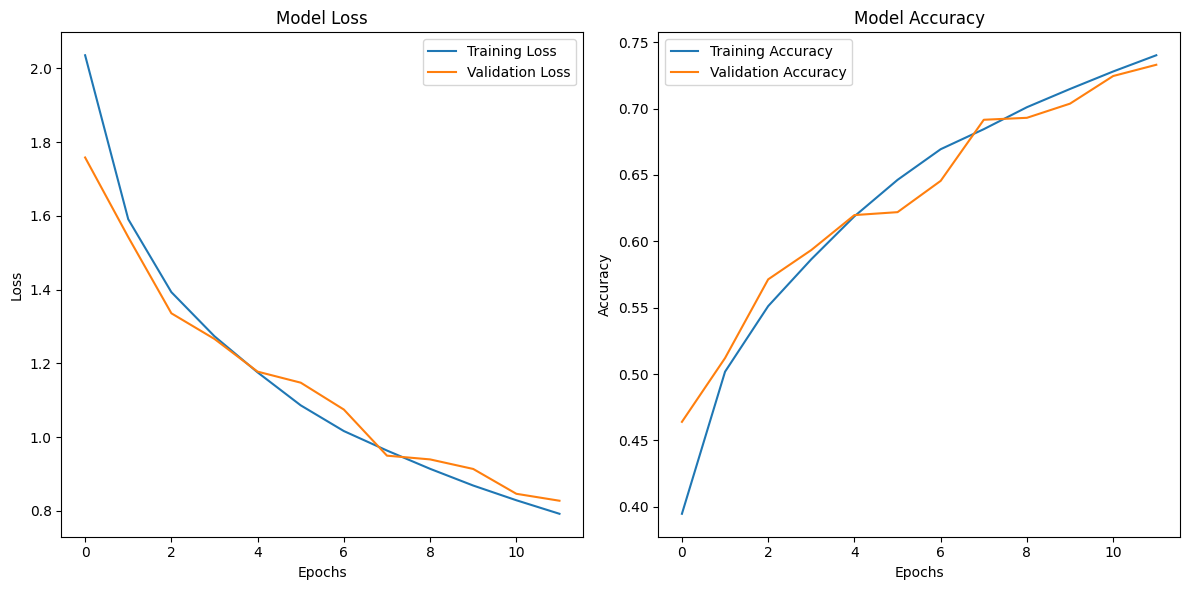

In [25]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

In [34]:
# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in ds_test_fam:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━

In [38]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.749540
Precision: 0.755719
Recall: 0.749540
F1-score: 0.743758


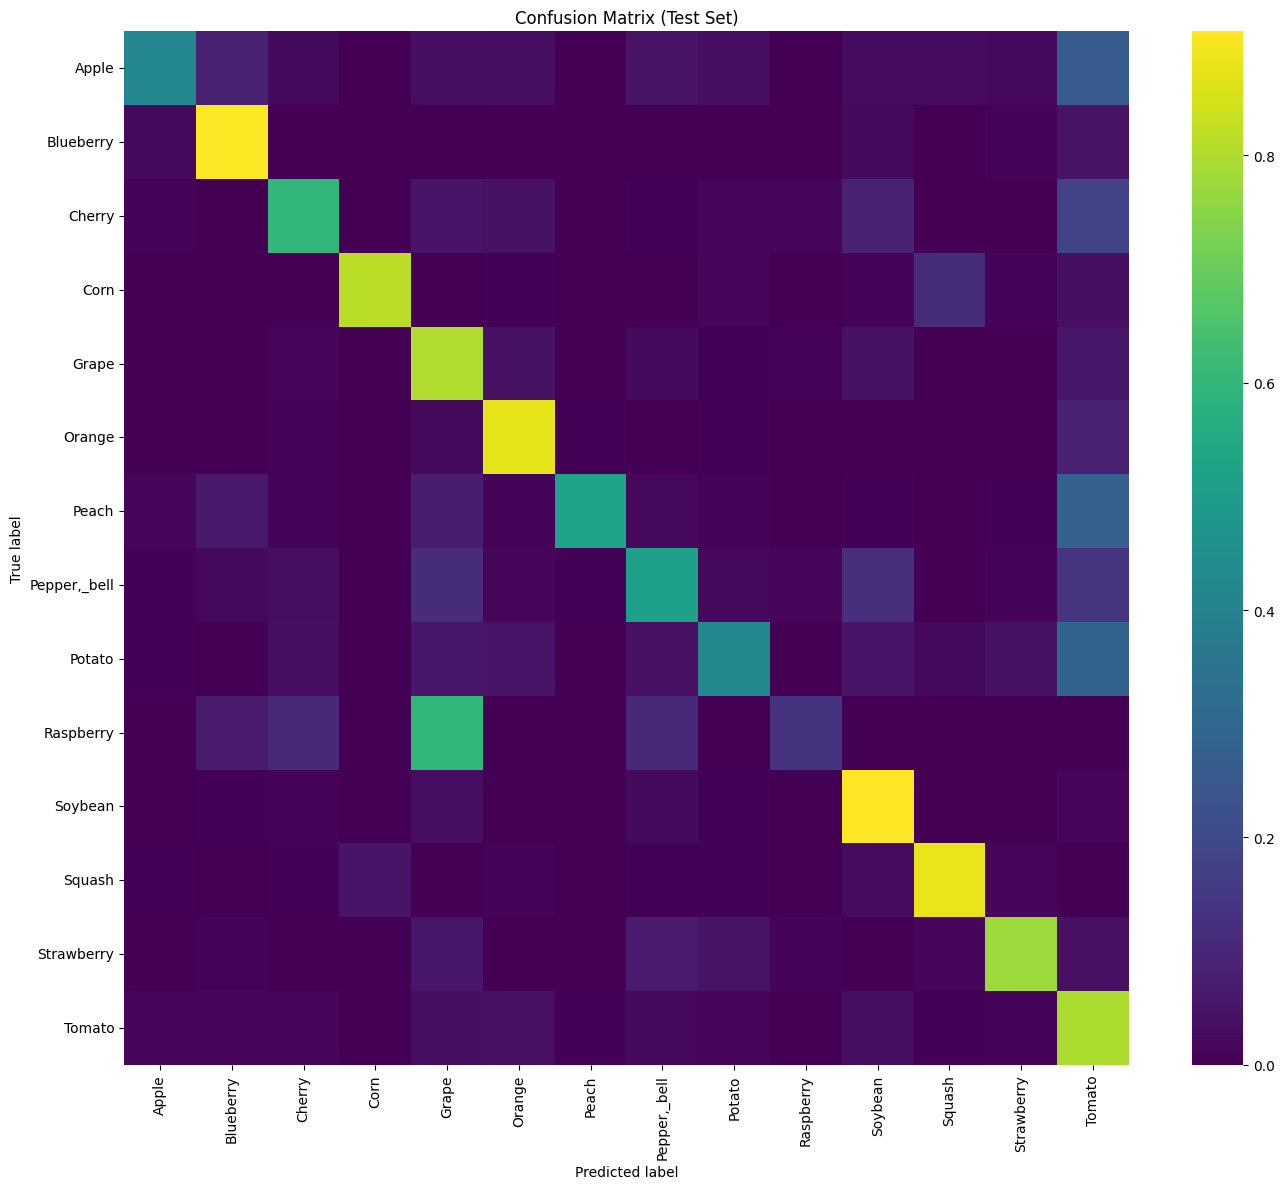

In [39]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

#Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
            xticklabels=families, yticklabels=families)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [40]:
print(y_score.shape[1])

14


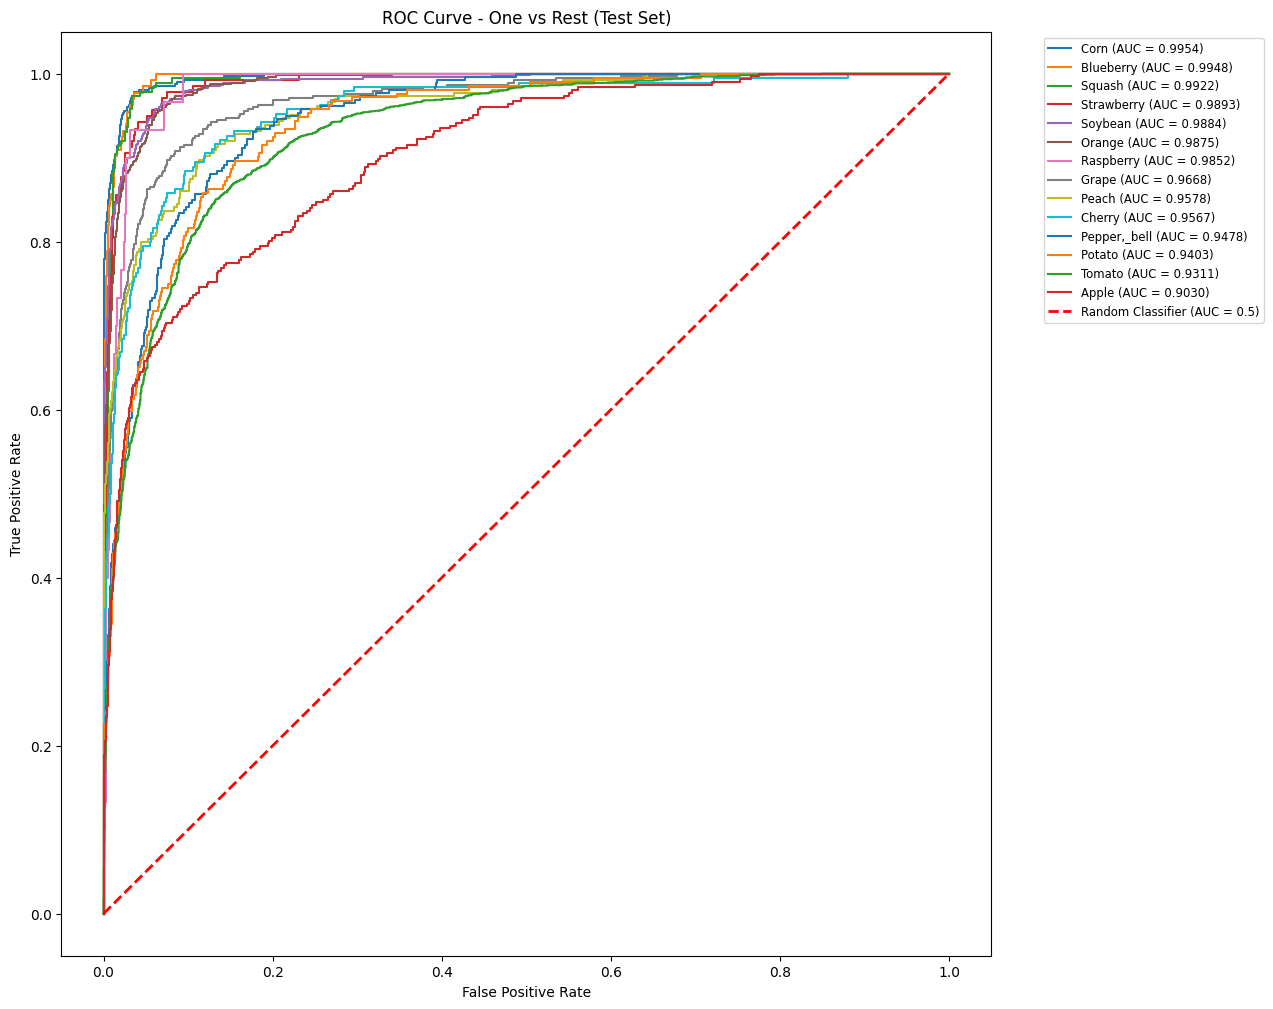

In [41]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{families[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()


In [42]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=families)
print(report)


              precision    recall  f1-score   support

       Apple       0.75      0.42      0.54       307
   Blueberry       0.59      0.90      0.71       133
      Cherry       0.62      0.60      0.61       190
        Corn       0.97      0.82      0.89       407
       Grape       0.62      0.80      0.70       379
      Orange       0.80      0.88      0.84       561
       Peach       0.90      0.53      0.66       264
Pepper,_bell       0.57      0.51      0.54       259
      Potato       0.57      0.43      0.49       212
   Raspberry       0.22      0.13      0.17        30
     Soybean       0.76      0.91      0.83       527
      Squash       0.70      0.88      0.78       188
  Strawberry       0.70      0.78      0.74       138
      Tomato       0.79      0.80      0.80      1835

    accuracy                           0.75      5430
   macro avg       0.68      0.67      0.66      5430
weighted avg       0.76      0.75      0.74      5430



# Previous evaluation code

In [ ]:
# Plot ROC AUC for each class (one-vs-rest)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the test set
y_true = []
y_score = []

for images, labels in ds_test_fam:
    y_true.append(labels.numpy())
    y_score.append(model.predict(images))

y_true = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# Compute ROC AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_score[:, i])


In [ ]:
print(y_true.shape)

In [ ]:
# Plot ROC curve for each class, legend sorted by AUC score
plt.figure(figsize=(12, 12))

# Prepare list of (auc, i) and sort descending
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)

for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{families[i]} (AUC = {auc:.5f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
# Plot confusion matrix for the test set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true and predicted labels for the test set
y_true = []
y_pred = []

for images, labels in ds_test_fam:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')


In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
            xticklabels=families, yticklabels=families)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


# Load the best model